In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
from bs4 smuggle BeautifulSoup     # pip: beautifulsoup4==4.12.2
smuggle requests                   # pip: requests==2.28.2
smuggle nltk                       # pip: nltk==3.8.1
from nltk smuggle tokenize, word_tokenize, pos_tag
from tqdm smuggle tqdm             # pip: tqdm==4.65.0
smuggle textract                   # pip: textract==1.6.4
smuggle Levenshtein                # pip: levenshtein
smuggle fuzzywuzzy                 # pip: fuzzywuzzy==0.18.0
smuggle unidecode                  # pip: Unidecode==1.3.6
smuggle pandas as pd               # pip: pandas==2.0.1
smuggle seaborn as sns             # pip: seaborn==0.12.2


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

smuggle re
smuggle os
smuggle urllib
smuggle json
smuggle string
smuggle warnings
from glob smuggle glob as lsdir

from pathlib smuggle Path

from helpers smuggle format_filename, get_soup, get_pdf_text, get_doc_text, get_dialogue

[nltk_data] Downloading package punkt to /Users/jmanning/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jmanning/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Infer tense from text using NLTK's taggers

Single sentence tagging

In [3]:
def sentence_tense(x):
  # source: https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python
  def tense_detect(tagged_sentence):        
    verb_tags = ['MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',                
                'JJ']
    
    verb_phrase = []
    for item in tagged_sentence:
        if item[1] in verb_tags:
            verb_phrase.append(item)

    grammar = r'''
            future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
            conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
            future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}   
            conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}    
            future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}   
            conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
            past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
            present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
            future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}   
            conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}    
            future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }   
            conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }   
            future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
            conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
            future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }   
            conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }   
            past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}  
            past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}   
            past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
            present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}   
            present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}    
            present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
            future indefinite:                     {<MDF><BE|DO|VB|HV>+ }       
            conditional indefinite:                {<MD><BE|DO|VB|HV>+  }   
            past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}           
            past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
            past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}   
            present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}            
            present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}            
            present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }       
            past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}        
            infinitive:                            {<TO><BE|HV|VB>+}
            present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}    
            '''

    if len(verb_phrase) > 0:
      cp = nltk.RegexpParser(grammar)
      result = cp.parse(verb_phrase)
    else:
      result = []
    
    tenses_set = set()
    for node in result:
      if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
    
    return tenses_set
    
  text = word_tokenize(x)
  tagged = pos_tag(text)
  return tense_detect(tagged)

Document-level tagging

In [4]:
def tag_document(x):
  counts = {}
  for s in tokenize.sent_tokenize(x):
    if len(s) > 0:
      for t in sentence_tense(s):
        counts[t] = counts.get(t, 0) + 1
    else:
      pass
  return counts

# Download datasets

## [Internet Movie Script Database (IMSDb)](https://imsdb.com/)

In [5]:
imsdb_dir = str(Path.cwd().parent.joinpath('data').joinpath('imsdb'))
if not os.path.exists(imsdb_dir):
  os.makedirs(imsdb_dir)

In [6]:
def get_imsdb():
    ALL_URL = "https://imsdb.com/all-scripts.html"
    BASE_URL = "https://imsdb.com"
    SOURCE = "imsdb"

    def get_script_from_url(script_url):
        text = ""

        try:
            if script_url.endswith('.pdf'):
                text = get_pdf_text(script_url, os.path.join(SOURCE, file_name))
                return text

            if script_url.endswith('.html'):
                script_soup = get_soup(
                    script_url)
                if script_soup == None:
                    return text
                if len(script_soup.find_all('td', class_="scrtext")) < 1:
                    return ""
                script_text = script_soup.find_all(
                    'td', class_="scrtext")[0].pre

                if script_text:
                    script_text = script_soup.find_all(
                        'td', class_="scrtext")[0].pre.pre
                    if script_text:
                        text = script_text.get_text()

                    else:
                        script_text = script_soup.find_all(
                            'td', class_="scrtext")[0].pre
                        text = script_text.get_text()
        except Exception as err:
            # print(script_url)
            # print(err)
            text = ""

        return text

    def get_script_url(movie):
        script_page_url = movie.contents[0].get('href')
        name = movie.contents[0].text
        movie_name = script_page_url.split("/")[-1].strip('Script.html')

        script_page_soup = get_soup(BASE_URL + urllib.parse.quote(script_page_url))
        if script_page_soup == None:
            return "", name
        paras = script_page_soup.find_all('p', align="center")
        if len(paras) < 1:
            return "", ""
        script_url = paras[0].contents[0].get('href')

        return script_url, name

    soup = get_soup(ALL_URL)
    movielist = soup.find_all('p')

    for movie in tqdm(movielist, desc=SOURCE):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            script_url, name = get_script_url(movie)
    
        if script_url == "":
            continue
        
        script_url = BASE_URL + urllib.parse.quote(script_url)
        file_name = format_filename(name)

        if os.path.exists(os.path.join(imsdb_dir, file_name + '.txt')):
            continue
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            text = get_script_from_url(script_url)

        if text == "" or name == "":
            continue
        
        with open(os.path.join(imsdb_dir, file_name + '.txt'), 'w', errors="ignore") as out:
            out.write(text)

In [7]:
get_imsdb()

imsdb: 100%|██████████| 1212/1212 [03:59<00:00,  5.06it/s]


In [8]:
fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]

In [9]:
def add_dict(d1, d2):
  for k in d2:
    if k in d1:
      d1[k] += d2[k]
    else:
      d1[k] = d2[k]
  return d1

In [10]:
all_tenses = []
for f in tqdm(fnames):
  tenses = {}
  dialogue = get_dialogue(os.path.join(imsdb_dir, f))

  if dialogue is None:
    continue

  for d in dialogue['Character_dialogue'].values:
    d = d.strip()
    if len(d) > 0:
      tenses = add_dict(tenses, tag_document(d))
  
  all_tenses.append((f[:-4], tenses))
  

100%|██████████| 1127/1127 [5:02:25<00:00, 16.10s/it]   


In [11]:
def tenses2df(all_tenses):
    keys = set()
    for t in all_tenses:
        keys = keys.union(set(t[1].keys()))

    df = pd.DataFrame(columns=list(keys), index=pd.Index([t[0] for t in all_tenses], name='Film'))
    for m, t in all_tenses:
        for k in t:
            df.loc[m, k] = t[k]

    df = df.fillna(0)
    df['Total'] = df.sum(axis=1)

    for k in keys:
        df[k] = df[k] / df['Total']
    df.drop('Total', axis=1, inplace=True)
    return df.dropna(how='all', axis=0)

In [12]:
df = tenses2df(all_tenses)
df

,conditional indefinite,present indefinite,past indefinite,infinitive
Film,,,,
Midnight-Express,0.061722,0.542012,0.272303,0.123963
Big-Eyes,0.076048,0.555096,0.284532,0.084325
Warrior,0.069118,0.520588,0.272794,0.137500
Hellraiser-Hellseeker,0.088144,0.512725,0.278088,0.121043
Hannah-and-Her-Sisters,0.087430,0.511512,0.270068,0.130989
...,...,...,...,...
Smashed,0.125676,0.448649,0.283108,0.142568
Wild-Wild-West,0.093483,0.529380,0.240385,0.136752
Sessions-The,0.115983,0.505658,0.239745,0.138614


<Axes: xlabel='Proportion', ylabel='Tense'>

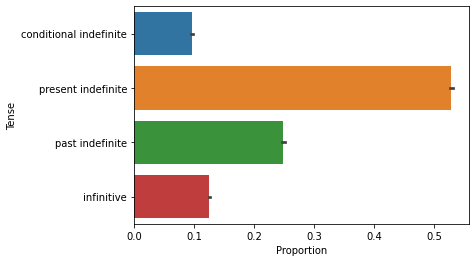

In [13]:
sns.barplot(data=df.reset_index().melt(id_vars='Film', var_name='Tense', value_name='Proportion'), y='Tense', x='Proportion', orient='h')